# Cohort Project - DWave Data Set


## Team Notes - Update

1 - Based on the DWave notes (see below) and found paper (note 1) it appears that we have data that provides for solving an Inverse pairwise problem (**team review needed to assist staying on track to what is asked, and not go beyond too soon**)

2 - DWave solves Ising Hamiltonians using an Ising or QUBO solver

3 - We do not have to use the actual DWave QPU to build and test our model, so if we do not yet have a DWave key we can still publish by the deadline. 

4 - One can always sign up on DWave leap to get a free "minute" of computing time (one minute is a lot in Quantum processing)











## DWave README.md content - with notes

# Ising data set
The provided data set is a collection of samples from an Ising Hamiltonian with pairwise interactions.

> [Note 1: see "Faster solutions of the inverse pairwise Ising problem"](https://arxiv.org/abs/0712.2437)


# Files

The following two files are provided:

* Training set: `train_{hashcode}.csv`
* Validation set: `val_{hashcose}.csv`
* List of pair of correlated variables: `correlated_features.csv`

You may use the first file to train a Boltzmann machine and use the second data set to validate the generative model.

# Tasks

1. Generate 10000 samples
2. Ensure the samples are generated from an equilibrated model. What metric do you use to prove equilibrium?
3. Report the mean of each Ising variable
4. Report the mean correlation of pairs of variables listed in `correlated_features.csv`

## Excepts from document from note (1)
Recent work has shown that probabilistic models based on pairwise interactions—in the simplestcase, the Ising model—provide surprisingly accurate descriptions of experiments on real biologicalnetworks ranging from neurons to genes.  **Finding these models requires us to solve an inverse prob-lem:  given experimentally measured expectation values, what are the parameters of the underlyingHamiltonian?**  This problem sits at the intersection of statistical physics and machine learning, andwe suggest that more efficient solutions are possible by merging ideas from the two fields.  We usea combination of recent coordinate descent algorithms with an adaptation of the histogram MonteCarlo method, and implement these techniques to take advantage of the sparseness found in data onreal neurons.  The resulting algorithm learns the parameters of an Ising model describing a networkof forty neurons within a few minutes.  This opens the possibility of analyzing much larger data setsnow emerging, and thus testing hypotheses about the collective behaviors of these networks.

## Ising Hamiltonian

Note 2: Ising describing the state of neurons firing or not with pairwise interaction



>$P(\sigma) = \frac{1}{Z} exp[ - \sum_{i} h_{i}\sigma_{i}^2 - \frac{1}{2} \sum_{i\neq j} J_{ij}\sigma_{i}\sigma_{j}]$

Note 2b: The DWave specializes on the square braket portion of the formula, so modification and adaptation will probably be needed.

>$E(\sigma)=\displaystyle\sum_{i,j∈neigh}J_{i,j}\sigma_i \sigma_j+\displaystyle\sum_{i∈V}h_i\sigma_i$

## Inverse Problem 

Note 3: Inverse Problem definition

The inverse problem is to : 
> find the “magnetic fields” ${h_i}$ and “exchange interactions” ${J_{ij}}$ that reproduce the observed values of〈$σ_i$〉and〈$σ_iσ_j$〉

## Current Assessment 

Note 4: If correct, the assessment is that we would use the source data, use RBM to learn it and generate stable samples. Using the pairwise data set, we construct the Ising model for the DWave. We then apply a method (iterative?) to have the DWave propose sets of qubit states for a given Ising set of coefficients. It appears that these coefficients are what we want to generate which solves the Ising for the given data set.

## Ising vs QUBO

In Ising we use $\sigma \in \small{\begin{Bmatrix} -1 \\ +1 \end{Bmatrix}}$ (spins)

In QUBO we use $x \in \small{\begin{Bmatrix} 0 \\ 1 \end{Bmatrix}}$ (binary)

One may need to convert from one to the other as follows:

>$\sigma = (2x - 1)$

>$x = \cfrac {(\sigma + 1)}{2}$

This may require additional simplification of the Hamiltonian


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/My Drive/Quantum-CDL/ProjectFiles/CohortProject_2020-master/CohortProject_2020-master/Project_1_RBM_and_Tomography"


/content/drive/My Drive/Quantum-CDL/ProjectFiles/CohortProject_2020-master/CohortProject_2020-master/Project_1_RBM_and_Tomography


In [3]:
!pwd
import numpy as np
import torch
from RBM_helper import RBM
import csv
import sys
import importlib
import Plotters
importlib.reload(Plotters)
import Rydberg_energy_calculator

datapath = '../datasets/IsingSamplesDW/'
sys.path.append(datapath) 
import dwhelper as dw # Need to rename helper because python has a helper.py in the system path


/content/drive/My Drive/Quantum-CDL/ProjectFiles/CohortProject_2020-master/CohortProject_2020-master/Project_1_RBM_and_Tomography


## Helper RBM Trainer


In [4]:
class RBMTrainer():
    def __init__(self, n_vis, n_hin, training_data, validation_data):
        """
        RBMTrainer needs params to create an rbm and training data to work with
        """
        self.n_vis = n_vis
        self.n_hin = n_hin
        self.training_data = training_data
        self.validation_data = validation_data
        self.meanseries = None
        
    def reset_state(self):
        self.rbm = RBM(self.n_vis, self.n_hin)
        self.best_epoch = None
        self.best_evaluation = None
        self.stopping_criterion_reached = False

    def run(self, epochs=1000, lr=1e-2, lr_annealing='', anneal_start=0,
            n_train_samples=20000, test_interval=50,
            n_test_samples=20000, n_valid_samples=10000, n_final_samples=10000, stopping_patience=2, verbose=False,
            do_plot=False):
        """
        params:
            epochs - max number of epochs to train for
            lr - base learning rate
            lr_annealing - either 'lin' for linear annealing or 'geo' for
                            geometric annealing
            anneal_start - epoch at which to start lr annealing
            n_train_samples - number of samples to train with
            test_interval - how often (number of epochs) to stop and evaluate energy
            n_test_samples - how many samples to use for testings
                                more samples --> better statistical significance
            stopping_patience - how many times in a row the stopping criterion
                                    needs to be reached in order to stop early
                                    Set this to -1 to not stop early at all
            verbose - Whether to printout training progress indicators
            do_plot - Whether to have a live plot of the evaluated energy vs epochs
        Note: at the start of each run the state is reset
        """
        self.reset_state()
        
        n_train_samples = min(len(self.training_data), n_train_samples)
        n_valid_samples = min(len(self.validation_data), n_valid_samples)

        exact_energy = 0 # -4.1203519096
        print("calculating exact energy...")
        energies = Rydberg_energy_calculator.energy(self.validation_data[:n_valid_samples], self.rbm.wavefunction)
        exact_energy = energies.item()

        if verbose:
            print("Exact energy: ",exact_energy)

        # Stopping criterion
        # Difference between exact energy and simulated energy must be below this thresh
        diff_thresh = 1e-4

        if do_plot:
            plot_title = f"{self.n_hin} hidden neurons; training with {n_train_samples} samples; testing with {n_test_samples} samples"
            plotter = Plotters.XYPlotter(href=diff_thresh,
                                        title=plot_title,
                                        x_label="Epoch",
                                        y_label="Energy difference")
            %matplotlib inline

        patience_cnt = 0 # counter for stopping criterion
        for e in range(1, epochs+1):
            # do one epoch of training
            current_lr = lr
            if lr_annealing == 'lin' and e > anneal_start:
                current_lr *= (1 - (e - anneal_start) / (epochs - anneal_start + 1))
            elif lr_annealing == 'geo' and e > anneal_start:
                ratio = (1e-4 / lr) ** (1/(epochs-anneal_start))
                current_lr *= ratio ** (e - anneal_start)
            elif len(lr_annealing) and e > anneal_start:
                print("Warning: lr_annealing must be one of '', 'lin', or 'geo'")
            self.rbm.train(self.training_data[:n_train_samples], lr=current_lr)   
        
            # now generate samples and calculate the energy
            if e % test_interval == 0:
                if verbose:
                    print("\nEpoch: ", e)
                    print("lr: ", current_lr)
                    print("Sampling...")

                init_state = torch.zeros(n_test_samples, self.n_vis)
                RBM_samples = self.rbm.draw_samples(n_test_samples, init_state)

                if verbose:
                    print("Done sampling. Calculating energy...") 
        
                energies = Rydberg_energy_calculator.energy(RBM_samples, self.rbm.wavefunction) 
                if verbose:
                    print("Energy from RBM samples: ", energies.item())

                C = abs(energies.item() - exact_energy) # our "loss" function

                if do_plot:
                    plotter.update(e, C)

                # update metrics
                if self.best_evaluation is None or C < self.best_evaluation:
                    self.best_evaluation = C
                    self.best_epoch = e

                # stopping criterion
                if stopping_patience > 0 and C < diff_thresh:
                    patience_cnt += 1
                    if patience_cnt >= stopping_patience:
                        print(f'Algorithm stopped after {e} epochs with energy estimation {energies.item()}')
                        self.stopping_criterion_reached = True

                        break
                else:
                    patience_cnt = 0 # reset patience if we didn't hit the criterion

        # Calculate the mean of the ising variables from a final set
        # Since it is set by the project goal, we fix it to 10000

        if verbose:
            print("Calculating mean of %d samples" % n_final_samples)
        init_state = torch.zeros(n_final_samples, self.n_vis)
        RBM_samples = self.rbm.draw_samples(n_final_samples, init_state)
        f1 = RBM_samples.mean(axis=0)
        self.meanseries = f1.tolist()


        if verbose:
            print(f'Training finalised. Best epoch: {self.best_epoch}; Best evaluation: {self.best_evaluation}')

## Load the Training and Validation data from the DWave npz file


In [5]:
training_data, validation_data = dw.load_dataset(datapath + "dataset_x1a46w3557od23s750k9.npz")

In [6]:
train = torch.from_numpy(training_data)
val = torch.from_numpy(validation_data)
print (train.shape)
print (val.shape)


torch.Size([40000, 2041])
torch.Size([10000, 2041])


## Load the correlated features csv data

In [7]:
corr_feat = []
with open(datapath+'correlated_features.csv', newline='') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    corr_feat.append(row)

print (len(corr_feat))

#for r in cf:
#  print (r[0],r[1],r[2])



5975


The Rydberg Hamiltonian is:
    
$H = -\sum_{<i,j>} Vij (\sigma_i^z \sigma_j^z + \sigma_i^z + \sigma_j^z
    - \Omega \sum_i \sigma_i^z - h \sum_i \sigma_i^x)$

where $\sigma$'s are Pauli matrices. Now, this function calculates E = <$H$>.


## Using RBM Trainer



In [8]:
trainer = RBMTrainer(train.shape[1], 2, train, val)


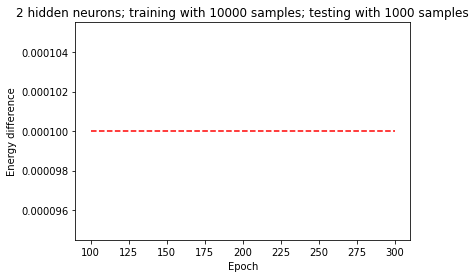


Epoch:  400
lr:  0.00023853323044733193
Sampling...
Done sampling. Calculating energy...


In [ ]:
epochs = 500            # 500
lr=5e-3                # 5e-3 
anneal_start=50        #
n_train_samples=10000    # 10000 
test_interval=100        # 100
n_test_samples=1000      # 1000
n_valid_samples=1000     # 10000
n_final_samples=10000    # 10000


trainer.run(epochs=epochs, lr=lr, lr_annealing='geo', anneal_start=anneal_start,
            n_train_samples=n_train_samples, test_interval=test_interval, n_test_samples=n_test_samples, n_valid_samples=n_valid_samples,n_final_samples=n_final_samples,
            stopping_patience=2, verbose=True, do_plot=True)


In [ ]:

plot_title = f"Mean of {len(validation_data[0])} Ising Variables in {n_final_samples} samples"
plotter = Plotters.XYPlotter(href=None,
                             title=plot_title,
                             x_label="Var",
                             y_label="Mean")
%matplotlib inline




In [ ]:
# Calculate Mean values of the resulting samples
freqs = trainer.meanseries
for i in range(len(freqs)):
  plotter.update(i,freqs[i],redraw_fig=False)
plotter._update_plot()
print(freqs)


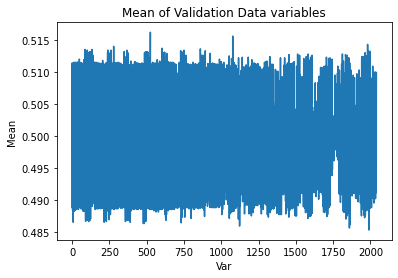

[0.51, 0.5114, 0.4887, 0.5111, 0.4883, 0.4887, 0.4882, 0.5113, 0.4865, 0.5112, 0.511, 0.5115, 0.4884, 0.5113, 0.4882, 0.4887, 0.4894, 0.5103, 0.51, 0.5115, 0.4884, 0.5114, 0.4884, 0.4886, 0.5113, 0.5113, 0.4885, 0.4885, 0.5115, 0.4886, 0.4885, 0.4886, 0.5107, 0.4893, 0.5114, 0.5114, 0.5115, 0.5114, 0.5115, 0.5114, 0.4888, 0.5111, 0.4885, 0.4885, 0.5114, 0.5114, 0.4889, 0.5114, 0.5114, 0.512, 0.5115, 0.5114, 0.5112, 0.5114, 0.511, 0.4889, 0.4887, 0.5113, 0.4887, 0.5114, 0.5112, 0.4886, 0.5113, 0.4893, 0.4888, 0.5114, 0.4887, 0.4886, 0.4888, 0.4886, 0.4887, 0.5109, 0.489, 0.5112, 0.5113, 0.4882, 0.5111, 0.4885, 0.4892, 0.5119, 0.4887, 0.4887, 0.5113, 0.4882, 0.4889, 0.4886, 0.4889, 0.5135, 0.5111, 0.4888, 0.4889, 0.4867, 0.5111, 0.4867, 0.4869, 0.4889, 0.5109, 0.4886, 0.5111, 0.5132, 0.488, 0.4869, 0.5134, 0.4882, 0.4882, 0.512, 0.49, 0.4868, 0.5122, 0.4869, 0.4869, 0.4869, 0.4866, 0.5111, 0.5096, 0.5131, 0.487, 0.5131, 0.487, 0.5117, 0.4868, 0.488, 0.4903, 0.5131, 0.487, 0.5131, 0.51, 0

In [31]:
plot_title = f"Mean of Validation Data variables"
plotter = Plotters.XYPlotter(href=None,
                             title=plot_title,
                             x_label="Var",
                             y_label="Mean")
%matplotlib inline

# Calculate Mean values of the validation data
f1 = validation_data.mean(axis=0)
freqs = f1.tolist()
for i in range(len(freqs)):
  plotter.update(i,freqs[i],redraw_fig=False)
plotter._update_plot()
print(freqs)

# Outline Plan

1.   Trainer from data set
2.   Sampler tests

 




## Add Code below to process the data

In [ ]:
#BASIC Template code - TO BE MODIFIED
from dwave.system import DWaveSampler, EmbeddingComposite

#Converts the QUBO into a BinaryQuadraticModel and then calls sample().
sampler = EmbeddingComposite(DWaveSampler())

#Example encoding for x0,x1,x2,x4: needs to be generalized based on dataset
Q = {('x0', 'x0'):1, ('x1', 'x1'):1, ('x2', 'x2'):1, ('x3', 'x3'):1, ('x4', 'x4'):1,}

results = sampler.sample_qubo(Q, num_reads=10000)

# print the results
for smpl, energy in results.data(['sample', 'energy']):
    print(smpl, energy)